In [3]:
%pip install numpy pandas matplotlib statsmodels

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Interactive widget
from ipywidgets import interact


# Retina mode
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [5]:
file_path = 'co2_mm_mlo.csv'
names = 'year,month,decimal date,average,deseasonalized,ndays,sdev,unc'.split(',')

# no index
df = pd.read_csv(file_path, skiprows=41, names=names, index_col=False)

In [6]:
df.index = pd.to_datetime(df[['year', 'month']].apply(lambda x: '{}-{}'.format(x[0], x[1]), axis=1))

In [7]:
# Create X and y

# X = months since first measurement

X = np.array(range(len(df)))
y = df.average.values

Text(0, 0.5, 'CO2 Level')

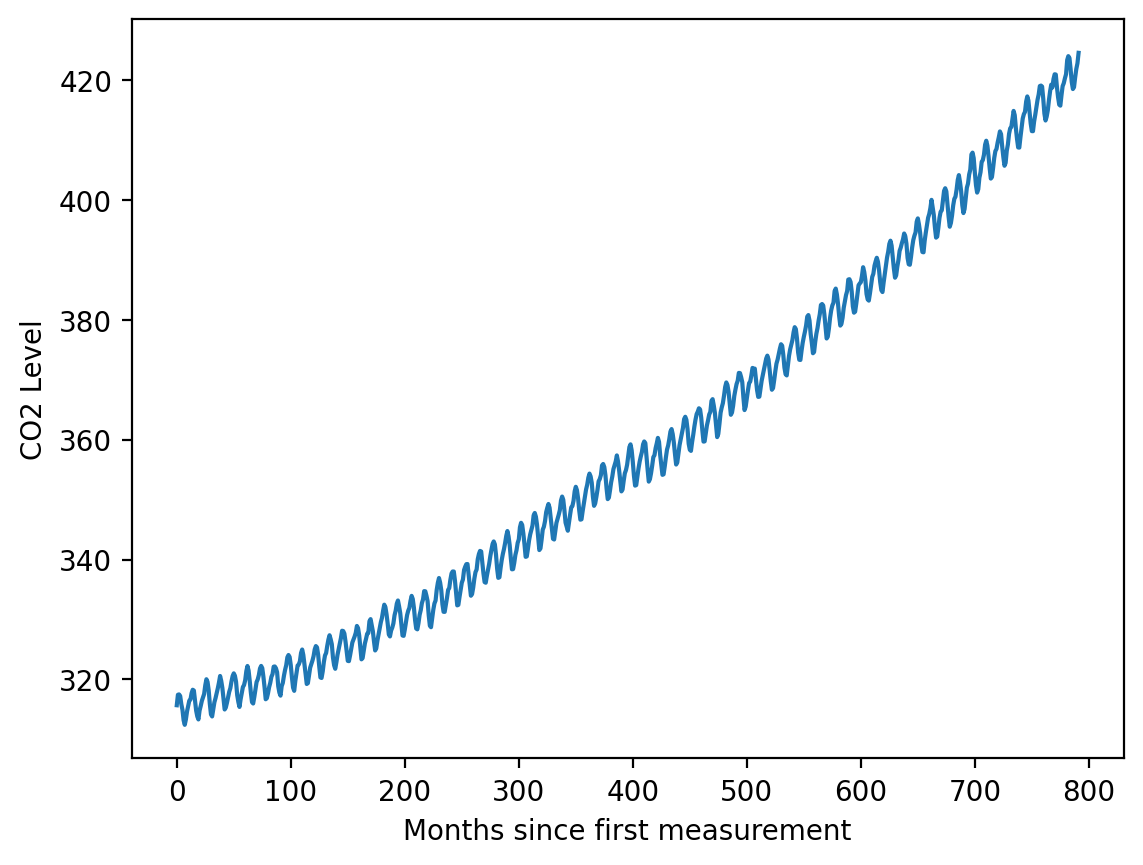

In [8]:
plt.plot(X, y)
plt.xlabel('Months since first measurement')
plt.ylabel('CO2 Level')

In [8]:
# Spliting the data into train and test, 80:20 split
y = y.flatten().tolist()
split_index = int(0.8 * len(y))

train_data = y[:split_index]
X_train_data = X[:split_index]
test_data = y[split_index:]
X_test_data = X[split_index:]

In [9]:
# making the features using previous values according to lag
def make_dataset(y, X, lag):
    X_train = []
    y_train = []
    months = []
    for i in range(len(y)-lag):
        row = y[i:i+lag]
        y_train.append(y[i+lag])
        X_train.append(row)

        month_value = X[i+lag]
        months.append(month_value)

    X_train = pd.DataFrame(X_train)
    y_train = pd.Series(y_train)
    return X_train, y_train, months

In [10]:
# adding the month value as a feature
def make_dataset_with_month(y, X, lag):
    X_train = []
    y_train = []
    months_train = []

    for i in range(len(y)-lag):
        row = y[i:i+lag]
        y_train.append(y[i+lag])
        X_train.append(row)

        month_value = X[i+lag]
        months_train.append(month_value)

    X_train = pd.DataFrame(X_train)
    X_train[10] = months_train
    y_train = pd.Series(y_train)

    return X_train, y_train, months_train

In [11]:
# example run of the model using a lag of 10
lag = 10
X_train, y_train, months_train = make_dataset(train_data, X_train_data, lag)
reg = LinearRegression().fit(X_train, y_train)
X_test, y_test, months_test = make_dataset(test_data,X_test_data, lag)
y_hat = reg.predict(X_test)
mse = mean_squared_error(y_test, y_hat)

print(f"Mean Squared Error (MSE): {mse}")

Mean Squared Error (MSE): 0.20568988246480083


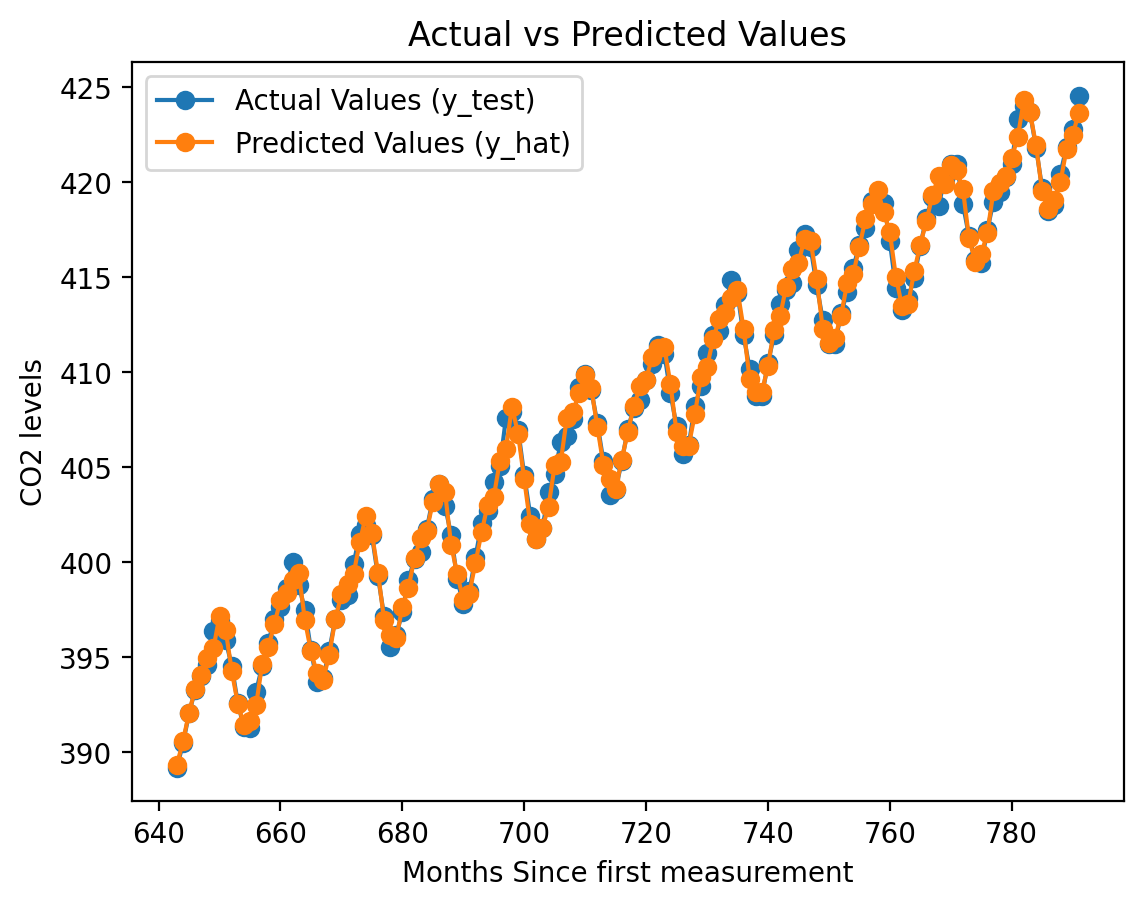

In [12]:
# Ploting the predicted output for lag=10 for the test sequence
plt.plot(months_test, y_test, label='Actual Values (y_test)', marker='o')
plt.plot(months_test, y_hat, label='Predicted Values (y_hat)', marker='o')
plt.xlabel('Months Since first measurement')
plt.ylabel('CO2 levels')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

Moving Average

Mean Squared Error (MSE) for Moving Average: 7.025762099739875


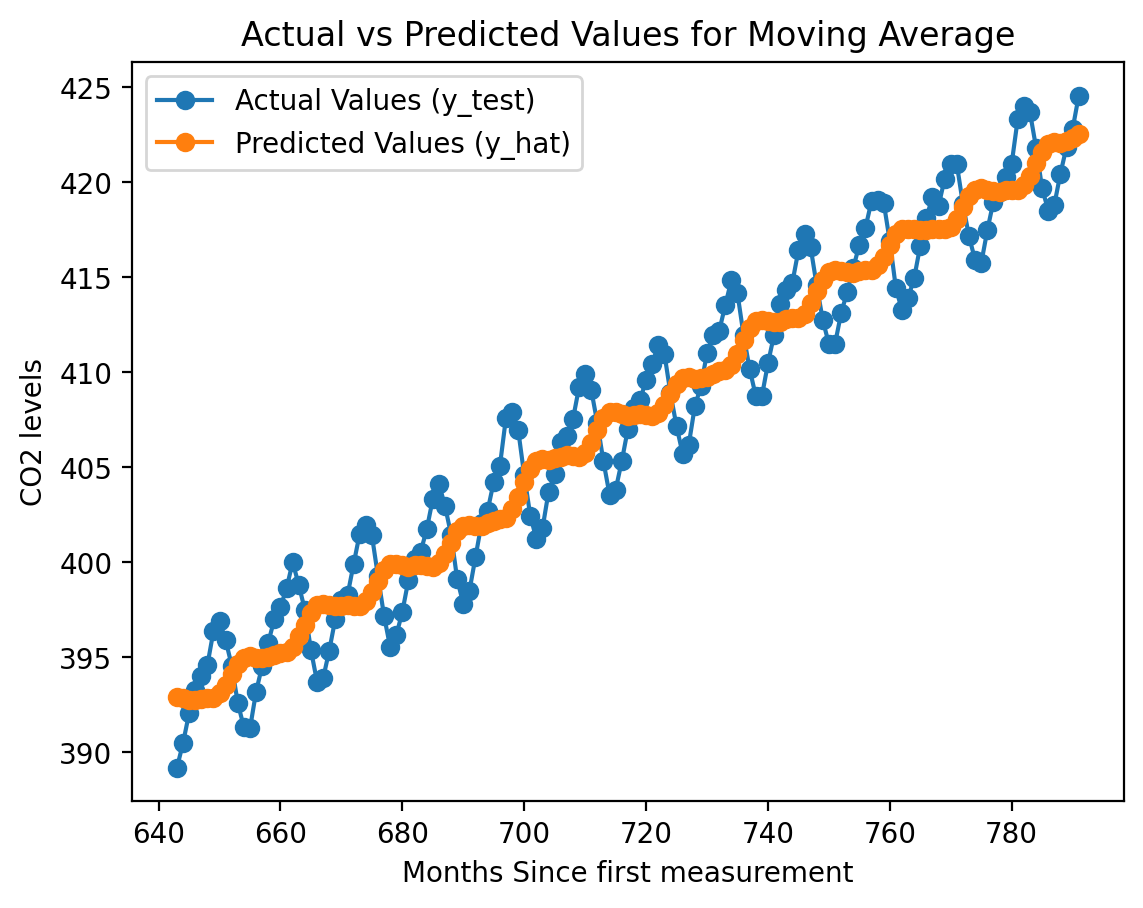

In [13]:
def make_dataset_ma(y, X, lag):
    X_train = []
    y_train = []
    months = []
    for i in range(len(y)-lag):
        row = y[i:i+lag]
        y_train.append(y[i+lag])
        X_train.append(pd.Series(row).mean())  # Calculate moving average
        month_value = X[i+lag]
        months.append(month_value)

    X_train = pd.Series(X_train)
    y_train = pd.Series(y_train)
    return X_train, y_train, months


# Example run of the model using a lag of 10 for moving average
lag = 10
X_train_ma, y_train_ma, months_train_ma = make_dataset_ma(train_data, X_train_data, lag)
reg_ma = LinearRegression().fit(X_train_ma.values.reshape(-1, 1), y_train_ma)
X_test_ma, y_test_ma, months_test_ma = make_dataset_ma(test_data, X_test_data, lag)
y_hat_ma = reg_ma.predict(X_test_ma.values.reshape(-1, 1))
mse_ma = mean_squared_error(y_test_ma, y_hat_ma)

print(f"Mean Squared Error (MSE) for Moving Average: {mse_ma}")
# Plotting the predicted output for lag=10 for the test sequence
plt.plot(months_test_ma, y_test_ma, label='Actual Values (y_test)', marker='o')
plt.plot(months_test_ma, y_hat_ma, label='Predicted Values (y_hat)', marker='o')
plt.xlabel('Months Since first measurement')
plt.ylabel('CO2 levels')
plt.title('Actual vs Predicted Values for Moving Average')
plt.legend()
plt.show()


ARMA

c:\Users\madha\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error (MSE) for ARMA(6,1): 41.633183961371614


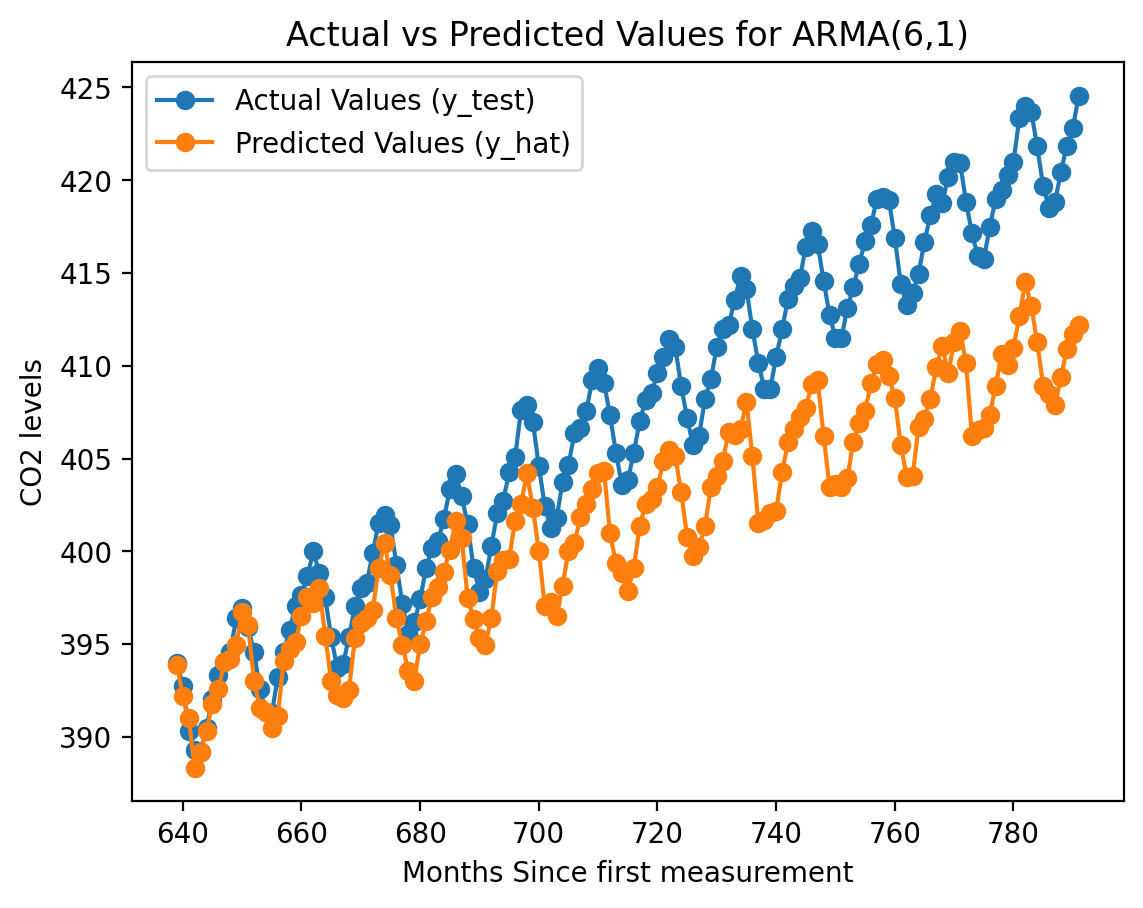

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Define a function to create dataset for ARMA model
def make_dataset_arma(y, X, p, q):
    X_train = []
    y_train = []
    months_train = []

    for i in range(max(p, q), len(y)):
        y_train.append(y[i])
        X_train.append(y[i-p:i] + X[i-q:i])  # Combine AR and MA terms
        months_train.append(X[i])

    return np.array(X_train), np.array(y_train), np.array(months_train)

# Example run of the model using ARMA(2, 1)
p = 6  # AR order
q = 1  # MA order

X_train_arma, y_train_arma, months_train_arma = make_dataset_arma(train_data, X_train_data, p, q)
X_test_arma, y_test_arma, months_test_arma = make_dataset_arma(test_data, X_test_data, p, q)

# Fit the ARMA model
model_arma = ARIMA(y_train_arma, order=(p, 0, q), exog=X_train_arma)
result_arma = model_arma.fit()

# Forecast
y_hat_arma = result_arma.forecast(steps=len(X_test_arma), exog=X_test_arma)

# Calculate Mean Squared Error (MSE)
mse_arma = np.mean((y_test_arma - y_hat_arma)**2)
print(f"Mean Squared Error (MSE) for ARMA({p},{q}): {mse_arma}")

# Plotting the predicted output for ARMA model
plt.plot(months_test_arma, y_test_arma, label='Actual Values (y_test)', marker='o')
plt.plot(months_test_arma, y_hat_arma, label='Predicted Values (y_hat)', marker='o')
plt.xlabel('Months Since first measurement')
plt.ylabel('CO2 levels')
plt.title(f'Actual vs Predicted Values for ARMA({p},{q})')
plt.legend()
plt.show()
